<div style="font-weight: bold; color:#5D8AA8" align="center">
    <div style="font-size: xx-large">Métodos Funcionales en Aprendizaje Automático</div><br>
    <div style="font-size: x-large; color:gray">Homework 03 - Diffusion Maps</div><br>
    <div style="font-size: large">Authors</div>Luis Antonio Ortega Andrés<br>Antonio Coín Castro</div><hr>
</div>

**Initial Configuration**

This cell defines the configuration of Jupyter Notebooks.

In [22]:
%%html
<style>
    .qst {background-color: #b1cee3; padding:10px; border-radius: 5px; border: solid 2px #5D8AA8;}
    .qst:before {font-weight: bold; content:"Exercise"; display: block; margin: 0px 10px 10px 10px;}
    h1, h2, h3 {color: #5D8AA8;}
    .text_cell_render p {text-align: justify; text-justify: inter-word;}
</style>

In [23]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This cell imports the packages to be used.

In [24]:
import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors

from sklearn.datasets import make_blobs, make_swiss_roll, make_s_curve

from mpl_toolkits.mplot3d import Axes3D
Axes3D

matplotlib.rc('figure', figsize=(15, 5))

seed = 123
my_cmap = plt.cm.Spectral

# Introduction

This practical assignment consists in implementing the manifold learning method **Diffusion Maps**, following the *scikit-learn* template for manifold learning methods.

We will design two main functions: one for training the algorithm, obtaining the affinity matrix and the embedded coordinates, and a second one for extending these coordinates for new patterns.

# Requirements

The objective of this assignment is to complete the class DM sketched below, which should contain at least the following methods.

`__init__(self, sigma, n_components, step=1, alpha=1)`

* This is the construction method for the class, with the following parameters:
    * `sigma`: Kernel parameter for the Gaussian kernel.
    * `n_components`: dimension of the embedding.
    * `step`: step in the Markov Chain.
    * `alpha`: density influence. It should a value in `[0,1]`.
* This method should only store the parameters in fields of the class, to be used when needed.

`fit(self, X, y=None)`

* This is the training method, the one that performs the Diffusion Maps algorithm. 

* This method should store the affinity matrix and also the eigenvectors to computed the transformation.

`fit_transform(self, X, y=None)`

* This method returns the embedding coordinates for the training data.
* It should also store the affinity matrix and the coordinates needed to compute the transformation (for example over new, unseen patterns).

`transform(self, X)`

* This method will obtain approximated coordinates for new, unseen data points. 
* It uses for this purpose the Nyström Formula.

## Some recommendations

* It should allow to fix all the DM possibilities (different steps, density normalization...). To allow a change in the kernel function could be also a nice idea.
* Implement all the auxiliary functions that you may need, for example, for deciding the best parameter values in each case.
* It could be a nice idea to offer a deterministic output, that do not depend on the sign of the eigenvectors.

# Implementation

<div class="qst">

* Complete the `DM` class below, satisfying the described requirements.

</div>

In [26]:
import warnings

import numpy as np

from sklearn.base import BaseEstimator
from sklearn.exceptions import NotFittedError
from sklearn.metrics.pairwise import (
    rbf_kernel, laplacian_kernel, pairwise_distances
)


def deterministic_vector_sign_flip(u):
    """Modify the sign of vectors for reproducibility.

    Utility function that flips the sign of elements
    of all the vectors (rows of u) such that the absolute
    maximum element of each vector is positive.

    Available in sklearn/utils/exmath.py.

    Parameters
    ----------
    u : ndarray of shape (N, M)
        Array with vectors as its rows.

    Returns
    -------
    u_flipped : ndarray of shape (N, M)
        Array with the sign flipped vectors as its rows.
    """
    max_abs_rows = np.argmax(np.abs(u), axis=1)
    signs = np.sign(u[range(u.shape[0]), max_abs_rows])
    u *= signs[:, np.newaxis]
    return u


def diagonalize(M):
    """Compute the eigenvalues and eigenvectors of a given square matrix.

    The matrix is not assumed to be symmetric, and the eigenvalues
    are returned in decreasing order of magnitude. The eigenvalue
    at position i corresponds with the eigenvector at position i.

    Parameters
    ----------
    M : ndarray
        Matrix to diagonalize.
    Returns
    -------
    eigvals : ndarray of shape (N,)
        Array with the eigenvalues
    eigvecs : ndarray of shape (N, N)
        Array with the eigenvectors as its columns.
    """
    # Get eigenvalues and right eigenvectors
    eigvals, eigvecs = np.linalg.eig(M)

    # Check that complex part is negligible and ignore it
    if np.iscomplexobj(eigvals):
        threshold_imaginary_part = 1e-6
        max_imaginary_part = np.max(
            np.abs(np.imag(eigvals))
        )
        if max_imaginary_part > threshold_imaginary_part:
            warnings.warn(
                "Maximum imaginary part is {}".format(
                    max_imaginary_part)
            )
        eigvals = np.real(eigvals)
        eigvecs = np.real(eigvecs)

    # Sort in descending order
    idx = eigvals.argsort()[::-1]

    return eigvals[idx], eigvecs[:, idx]


class DiffusionMaps(BaseEstimator):
    """Diffusion Maps algorithm for manifold learning [1].

    The data is used to define a weighted graph based on
    kernel similarity, then a random walk over the graph
    is defined, and finally the transition probabilities are
    used to find an embedding to a lower-dimensional space.

    Parameters
    ----------
    n_components : int or float
        Dimension of the embedded space. If it is a float,
        it represents the desired relative precision in the
        (Euclidean) distance approximation.
    step : int
        Number of steps to advance in the underlying Markov chain.
    alpha : float
        Normalization parameter that controls the density influence.
    affinity : {'rbf', 'laplacian', 'precomputed'} or callable
        How to construct the affinity matrix. If 'precomputed', the data matrix
        itself is interpreted as an affinity matrix.
        If a callable, it should have the signature 'affinity(X, Y=None)',
        with the understanding that when Y=None the affinity between X and
        itself is computed.
    sigma : float or {'percentile', 'maximum', 'auto'}
        Kernel width parameter for rbf and laplacian kernels. The meaning of
        the possible string values is the following:
            - 'percentile': a percentile of the pairwise distances of the
             data, specified by `self.p`.
            - 'maximum': the maximum of the pairwise distances of the data.
            - 'auto': it has the same meaning as in Sklearn.
     p : float
        Percentile for calculating sigma. Ignored if `self.sigma` is not
        'percentile'.

    Attributes
    ----------
    n_components_ : int
        Actual dimension of the embedding.
    sigma_ : float
        Sigma parameter effectively used. Only available if `self.affinity` is
        'rbf' or 'laplacian'.
    affinity_matrix_ : ndarray of shape (n_samples, n_samples)
        Affinity matrix constructed from samples or precomputed.
    embedding_ : ndarray of shape (n_samples, `self.n_components_`)
        Spectral embedding of the training matrix.
    References
    ----------
    [1] Coifman, R. R., & Lafon, S. (2006). Diffusion maps.
        Applied and computational harmonic analysis, 21(1), 5-30.
    """

    def __init__(
        self,
        n_components=2,
        step=1,
        alpha=1.0,
        affinity='rbf',
        sigma='percentile',
        p=50,
    ):
        """Construct a DiffusionMaps object."""
        self.n_components = n_components
        self.step = step
        self.alpha = alpha
        self.affinity = affinity
        self.sigma = sigma
        self.p = p

    def _choose_sigma(self):
        """Handle the initialization of sigma."""
        if self.sigma == 'percentile':
            self.sigma_ = np.percentile(pairwise_distances(self._data), self.p)
        elif self.sigma == 'maximum':
            self.sigma_ = np.max(pairwise_distances(self._data))
        elif self.sigma == 'auto':
            self.sigma_ = np.sqrt(self._data.shape[1]/2.)
        elif isinstance(self.sigma, (int, float)):
            if self.sigma <= 0:
                raise ValueError(
                    ("sigma must be positive. Got %s") % self.sigma)
            self.sigma_ = self.sigma
        else:
            raise ValueError(("%s is not a valid sigma parameter. "
                              "Expected 'percentile', 'maximum', 'auto' "
                              "or a float.") % self.sigma)

    def _choose_n_components(self, eigvals):
        r"""Handle the initialization of the embedding dimension.

        If a float value is specified in `self.n_components`, the
        following formula is used:
        ```
            n\_components = \max_{l} |\lambda_l|^T > \delta |\lambda_1|^T.
        ```
        """
        if isinstance(self.n_components, int):
            self.n_components_ = self.n_components
        elif isinstance(self.n_components, float):
            self.n_components_ = np.argmin(
                np.abs(eigvals)**self.step >
                self.n_components*np.abs(eigvals[0])**self.step)
        else:
            raise ValueError(("%s is not a valid n_components parameter. "
                              "Expected int of float.") % self.n_components)

    def _get_affinity_matrix(self, X, Y=None):
        """Compute an affinity_matrix from samples."""
        if not hasattr(self, "sigma_"):
            self._choose_sigma()

        if self.affinity == 'rbf':
            return rbf_kernel(X, Y, gamma=1/(2*self.sigma_**2))
        if self.affinity == 'laplacian':
            return laplacian_kernel(X, Y, gamma=1/(2*self.sigma_**2))
        if self.affinity == 'precomputed':
            return X
        return self.affinity(X, Y)

    def fit(self, X, y=None):
        """Compute the embedding vectors for training data.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training set.

            If `self.affinity` is 'precomputed'
            X : ndarray of shape (n_samples, n_samples)
            Interpret X as an adjacency graph computed from samples.
        y : Ignored

        Returns
        -------
        self : object
            Returns the instance itself.
        """
        self._data = X

        if isinstance(self.affinity, str):
            if self.affinity not in {"rbf", "laplacian", "precomputed"}:
                raise ValueError(("%s is not a valid kernel. Expected "
                                  "'precomputed', 'rbf', 'laplacian' "
                                  "or a callable.") % self.affinity)
        elif not callable(self.affinity):
            raise ValueError(("'affinity' is expected to be a kernel "
                              "name or a callable. Got: %s") % self.affinity)

        # Compute affinity matrix
        self.affinity_matrix_ = self._get_affinity_matrix(X)

        # Degree diagonal matrix (add 1e-9 to avoid division by zero)
        degree_v = (np.sum(
            self.affinity_matrix_, axis=1) + 1e-9)**(-self.alpha)
        Dv = np.diag(degree_v)

        # Density normalization
        K_alpha = Dv@self.affinity_matrix_@Dv
        D_alpha = np.sum(K_alpha, axis=1).reshape(-1, 1) + 1e-9

        # Transition probability matrix
        P = K_alpha/D_alpha

        # Eigendecomposition of P
        eigvals, eigvecs = diagonalize(P)
        self._choose_n_components(eigvals[1:])
        self._eigvals = eigvals[1:self.n_components_ + 1]
        eigvecs = eigvecs[:, 1:self.n_components_ + 1]
        self._eigvecs = deterministic_vector_sign_flip(eigvecs.T).T

        # Embedding
        self.embedding_ = (self._eigvals**self.step)*self._eigvecs

        return self

    def diffusion_distance(self):
        """Compute the diffusion distance approximation matrix."""
        if not hasattr(self, "embedding_"):
            raise NotFittedError("The object was not fitted.")

        return pairwise_distances(self.embedding_, metric='sqeuclidean')

    def fit_transform(self, X, y=None):
        """Compute the embedding vectors for data X and transform X.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training set.

            If `self.affinity` is 'precomputed'
            X : ndarray of shape (n_samples, n_samples)
            Interpret X as an adjacency graph computed from samples.
        y : Ignored

        Returns
        -------
        X_red : ndarray of shape (n_samples, `self.n_components_`)
            The transformed training data.
        """
        self.fit(X)
        return self.embedding_

    def transform(self, X):
        """Transform X using the Nyström formula for out-of-sample embedding.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Data to be transformed.

        Returns
        -------
        X_red : ndarray of shape (n_samples, `self.n_components_`)
            The transformed data.
        """
        if not hasattr(self, "embedding_"):
            raise NotFittedError("The object was not fitted.")

        if np.array_equal(self._data, X):
            return self.embedding_

        K = self._get_affinity_matrix(X, self._data)
        Dv_left = np.diag((np.sum(K, axis=1) + 1e-9)**(-self.alpha))
        Dv_right = np.diag((np.sum(K, axis=0) + 1e-9)**(-self.alpha))
        K_alpha = Dv_left@K@Dv_right
        D_alpha = np.sum(K_alpha, axis=1).reshape(-1, 1) + 1e-9
        P = K_alpha/D_alpha

        return (1./self._eigvals)*(P@self._eigvecs)

## Spectral embedding comparison

First of all, we perform a small test where we verify that our algorithm gives the same results than Sklearn's `SpectralEmbedding`, provided that we choose $T = \alpha = 0$ and the same value of $\sigma$ (in that case both algorithms should be equivalent).

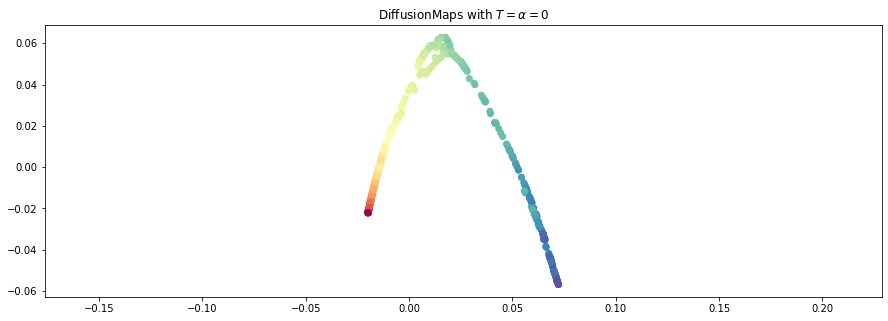

In [28]:
N = 1000
X, color = make_swiss_roll(N, random_state=seed)

dm = DiffusionMaps(n_components=2, sigma=1.0, step=0, alpha=0)
X_red = dm.fit_transform(X)

plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.axis('equal')
plt.title(r"DiffusionMaps with $T=\alpha=0$")
plt.show()

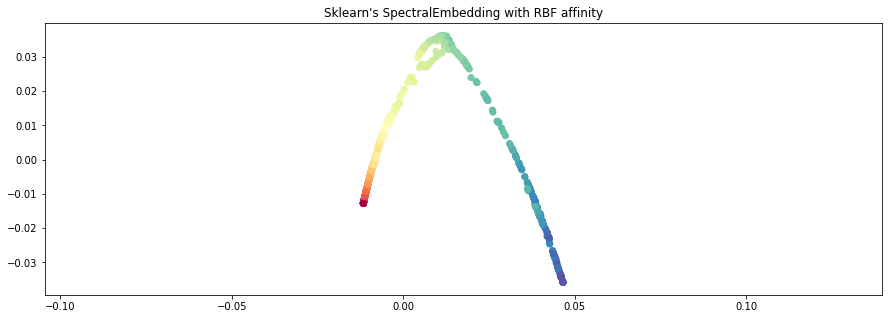

In [29]:
from sklearn.manifold import SpectralEmbedding

se = SpectralEmbedding(affinity='rbf', gamma=0.5)
X_red_sk = se.fit_transform(X)

plt.scatter(X_red_sk[:, 0], X_red_sk[:, 1], c=color, cmap=my_cmap)
plt.axis('equal')
plt.title("Sklearn's SpectralEmbedding with RBF affinity")
plt.show()

# Experiments with DM

<div class="qst">

* Obtain some good embedded coordinates for the three training datasets specified below.
    
* Extend its coordinates for the new points.
    
</div>

We define a scaler object to standardize our data prior to applying the algorithm.

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

## Dataset 1: two blobs

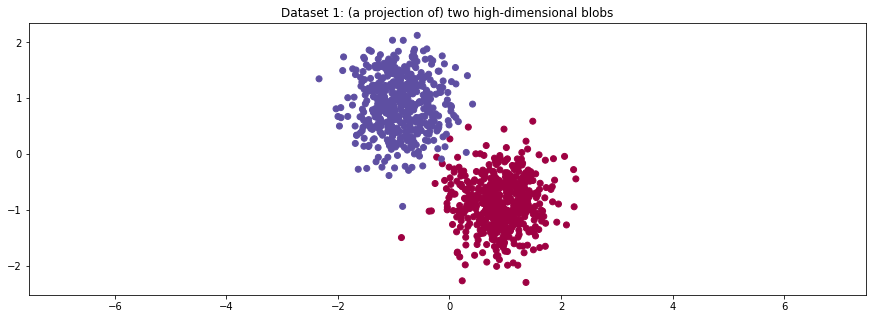

In [60]:
N = 1000

X, y = make_blobs(n_samples=N, n_features=50, centers=2,
                  cluster_std=3.0, random_state=seed)
X = scaler.fit_transform(X)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
plt.axis('equal')
plt.title("Dataset 1: (a projection of) two high-dimensional blobs")
plt.show()

N_new = 100
X_new, y_new = make_blobs(n_samples=N_new, n_features=50, centers=2,
                          cluster_std=3.0, random_state=seed+1)
X_new = scaler.transform(X_new)

We can try our algorithm with the default parameters to see how it performs. We will try to obtain a two-dimensional embedding.

In [33]:
dm = DiffusionMaps(n_components=2)
X_red = dm.fit_transform(X)
print("Sigma:", dm.sigma_)

Sigma: 9.84111956098517


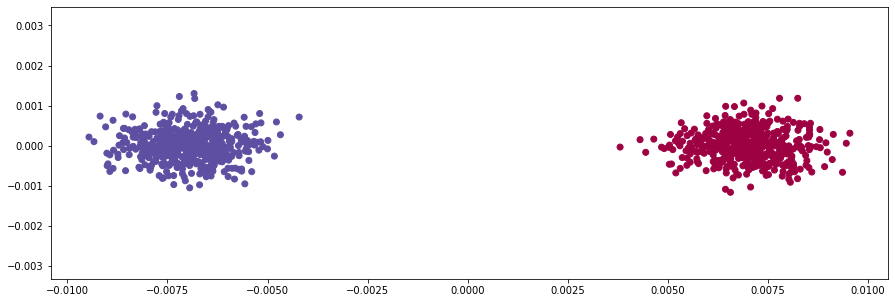

In [34]:
plt.scatter(X_red[:, 0], X_red[:, 1], c=y, cmap=my_cmap)
plt.axis('equal')
plt.show()

As we can see, the embedding on the training set is pretty good, since it completely separates the classes. Let's see how well it translates to previously unseen points.

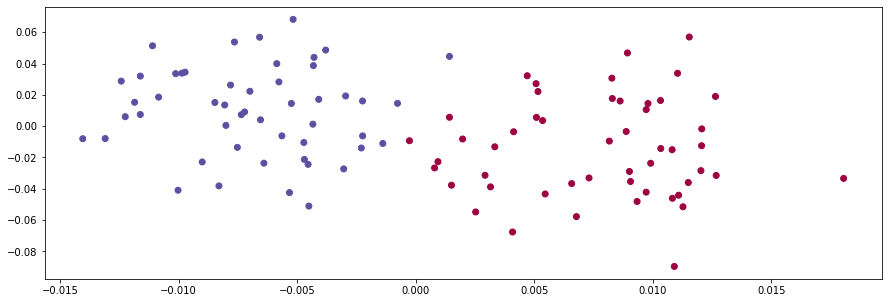

In [35]:
X_red_n = dm.transform(X_new)
plt.scatter(X_red_n[:, 0], X_red_n[:, 1], c=y_new, cmap=my_cmap)
plt.show()

Again, the embedding is quite good. Although not by a large margin, the embedded points are linearly separable.

## Dataset 2: the swiss roll

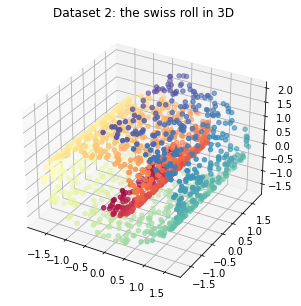

In [113]:
N = 1500
X, color = make_swiss_roll(n_samples=N, random_state=seed)
X = scaler.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=my_cmap)
plt.title("Dataset 2: the swiss roll in 3D")
plt.show()

N_new = 100
X_new, color_new = make_swiss_roll(n_samples=N_new, random_state=seed+1)
X_new = scaler.transform(X_new)

First of all we tried with the default parameters, varying the percentile to choose a suitable $\sigma$. We ended up choosing $p=1$ as the best distance percentile for the RBF kernel.

In [114]:
dm = DiffusionMaps(n_components=2, p=1)
X_red = dm.fit_transform(X)
print("Sigma:", dm.sigma_)

Sigma: 0.3628867593282024


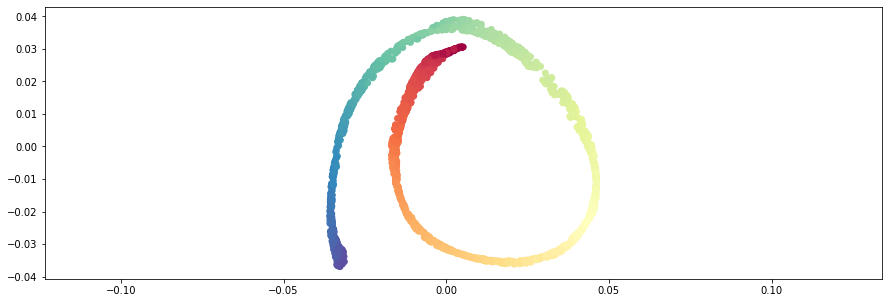

In [116]:
plt.scatter(X_red[:, 0], X_red[:, 1], c=color, cmap=my_cmap)
plt.axis('equal')
plt.show()

However, this embedding is not good. Although it preserves the distances between neighbours and would maybe be good for clustering, it doesn't *unroll* the swiss roll. After some experimentation, we found that an acceptable but still very improvable 2D embedding could be obtained if we used 3 components and projected only on the first and the third.

In [110]:
dm = DiffusionMaps(n_components=3, p=1)
X_red = dm.fit_transform(X)
print("Sigma:", dm.sigma_)

Sigma: 0.3628867593282024


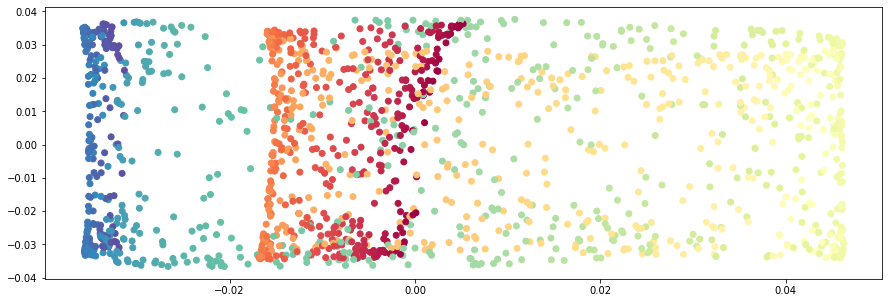

In [111]:
plt.scatter(X_red[:, 0], X_red[:, 2], c=color, cmap=my_cmap)
plt.show()

Finally, we apply Nyström's formula to obtain an embedding of new points from the same distribution.

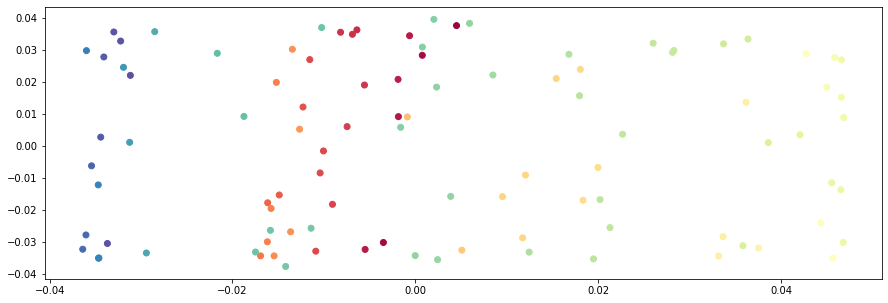

In [112]:
X_red_n = dm.transform(X_new)
plt.scatter(X_red_n[:, 0], X_red_n[:, 2], c=color_new, cmap=my_cmap)
plt.show()

## Dataset 3: the S curve

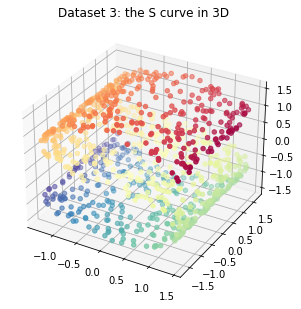

In [105]:
N = 1000
X, color = make_s_curve(N, random_state=seed)
X = scaler.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=my_cmap)
plt.title("Dataset 3: the S curve in 3D")
plt.show()

N_new = 100
X_new, color_new = make_s_curve(N_new, random_state=seed+1)
X_new = scaler.transform(X_new)

In this case, we directly applied the trick of choosing a 3-dimensional embedding and projecting on the first and third components. We tried a few values for the percentile parameter until we obtained a good embedding.

In [106]:
dm = DiffusionMaps(n_components=3, p=3)
X_red = dm.fit_transform(X)
print("Sigma:", dm.sigma_)

Sigma: 0.5774722144852045


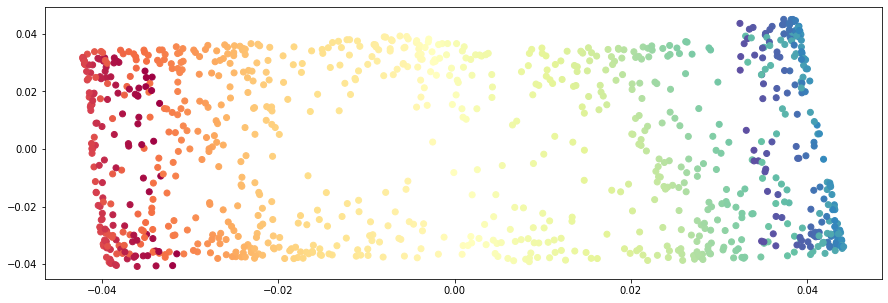

In [107]:
plt.scatter(X_red[:, 0], X_red[:, 2], c=color, cmap=my_cmap)
plt.show()

Nyström formula for unseen points works as well.

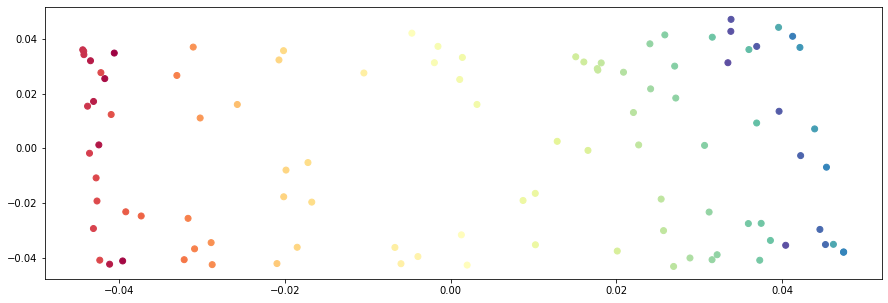

In [108]:
X_red_n = dm.transform(X_new)
plt.scatter(X_red_n[:, 0], X_red_n[:, 2], c=color_new, cmap=my_cmap)
plt.show()

## Exercises

<div class="qst">

1. Do you consider the embedding obtained is good for the previous datasets? Is it the expected one? Why?
    
2. How sensible is the method to its hyper-parameters? Specify the best values that you have found and the technique employed for it.      
    a) Check how much influence the sample density (you can vary N for each dataset).    
    b) Check what happens if the number of steps `steps` grows.
    
3. What do you think are the main advantage and disadvantage of this method?
    
</div>

**1.** First and foremost, the embedding of the two blobs dataset appears to be reasonable, and as one might expect, the two distinct blobs are more differentiated in the embedding than in the original dataset. The distance between the two classes in the embedding is drastically reduced when using Nyström to transform out-of-sample datapoints, but all in all their separability is preserved.

When dealing with the swiss roll, we could not find any set of parameters that correctly unroll the dataset in a 2D plane. The final embedding we are showing is just our best attempt, which only unrolls the dataset slightly.

Finally, the learned embedding correctly unrolls the S curve dataset, resulting in a nearly flat two-dimensional representation with perfect color gradient preservation. In this case, the generalization to out-of-sample points almost perfectly matches the previous pattern, resulting in a very good embedding.

---

**2.** In general, we have followed a trial-and-error approach when selecting the best hyperparameters for each dataset. In addition, since we implemented a sensible set of default parameters, in most cases the only thing we had to tune was the distance percentile at which $\sigma$ is chosen. We found that the method was quite sensible to this hyperparameter (the embeddings obtained were very different), and not very sensible, for example, to the choice of RBF or Laplacian kernel.

**2.a)** As the number of steps grows, the amount of relevant components in the embedding is decreased. This can be clearly explained if one recalls the embedding expression

$$
X_{red} = \lambda^{T}\psi.
$$

As $T$ grows, the difference between the bigger and the smaller eigenvalues gets higher, making the components corresponding to the former more relevant in the embedding. For example, in the first dataset given by the two blobs, if we significantly incresase the amount of steps, the result is the following:

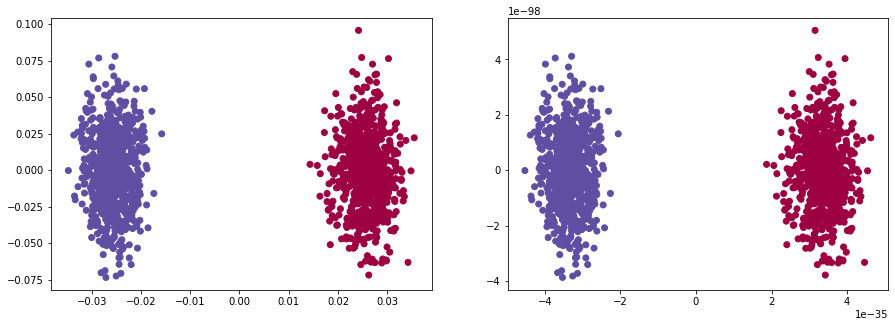

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
X, y = make_blobs(n_samples=N, n_features=50, centers=2,
                  cluster_std=3.0, random_state=seed)
X = scaler.fit_transform(X)

dm = DiffusionMaps(n_components=2, step=0)
X_red = dm.fit_transform(X)
axes[0].scatter(X_red[:, 0], X_red[:, 1], c=y, cmap=my_cmap)

dm = DiffusionMaps(n_components=2, step=50)
X_red = dm.fit_transform(X)
axes[1].scatter(X_red[:, 0], X_red[:, 1], c=y, cmap=my_cmap)

plt.show()

We can see how **the embedding has the same structure in both cases, but the scale ratio is much bigger when employing a higher amount of steps**.

**2.b)** On the other hand, the repercussion of the number of samples does only affect the computational cost of the method.

---

Diffusion process-based algorithms have two main advantages over traditional dimensionality reduction techniques (PCA and MDS): they are nonlinear and they preserve local structures. This is significant because the input data rarely falls on a linear manifold. Furthermore, in most cases, maintaining close distances is essential. Furthermore, in most cases, preserving distances between nearby points is more important than preserving distances between distant points.

Diffusion Maps have some benefits over Spectral Embeddings:

1. They're a more general approach.
2. They are based on Markov processes and a new metric, the Diffusion Distance, and have a solid theory behind them.
3. They are more versatile because they allow us to account for more steps in the diffusion processes as well as evaluate the density's significance.


The main disadvantage of this method is that its performance relies on the optimization of its hyperparameters. This could lead to situations as the one given by the Swiss roll, where we could not find a valid set of hyperparameters to produce a meaningfull embedding but that does not imply that it does not exist. Another major diasvantage of this method is its computational cost, being this $\mathcal{O}(N^3)$ as is usual in kernel methods. In this implementation we are using Nyström approximation for out-of-sample methods which loweres the model computational cost, but the fit method cannot be optimized any further without loosing performance.
